**Black-Scholes Model**

In the Black-Scholes model, the stock price follows a Geometric Brownian motion
\begin{equation}
dS_t = \mu \, S_t \, dt + \sigma \, S_t \, dW_t,
\end{equation}
where $\mu$ is the drift coefficient and $\sigma^2$ corresponds to the volatility. \
\
\
**Greeks and Delta-Hedging**

The Greeks give the sensitivity of the price of derivatives to a change in different parameters. \
They help to quantify the risk.\
In this notebook, we implement the Greeks for a Call and Put Option.

We also implement Delta-Hedging, by calculating the Delta of the option and buying the respective amount of shares so that the portfolio's Delta is zero.

In [1]:
# ========================== Black-Scholes and Greeks ===========================
# Author: Alexis D. Plascencia
# We implement the stochastic Black-Scholes Model for pricing
# We compute the Greeks for Call and Put Options
# ===============================================================================

import numpy as np
import matplotlib.pylab as plt
import scipy.stats as ss
import pandas as pd

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)


In [2]:
# Input Parameters:
paths = 4                            # Number of paths to be generated
mu = 0.05/365.0                      # Drift of stock price
sigma = 0.9/365.0                    # Variance of the variance                              
S0 = 100.0                           # Initial condition for the stock price
eps = 1.e-8                          # This is to avoid divergences

steps = 500
ti = 0
tf = 365
dt = (tf-ti)/steps
time = np.linspace(ti, tf, steps+1)

In [3]:
def BlackScholes(paths, mu, sigma, S0):

    # We initialize the vector
    S = np.zeros((paths,steps+1))
    
    # We set the initial condition
    S[:,0] = S0

    for i in range(steps):
        epsilon = np.random.normal(0., 1.0, paths)
        S[:,i+1] = S[:,i] + mu*dt*S[:,i] + sigma*np.sqrt(dt)*epsilon*S[:,i] 
    
    # We return the stock price as a function of time
    return S

In [4]:
def Option(S, K, T, r, q, sigma, CallPut):
    # We use the analytic solution for the Call and Put pricing
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2.)*(T-time))/(sigma*np.sqrt(T-time) + eps)
    d2 = d1 - sigma*np.sqrt(T-time)

    # For Call option:
    if CallPut == 'Call':
        return S*np.exp(-q*(T-time))*ss.norm.cdf(d1) - K*np.exp(-r*(T-time))*ss.norm.cdf(d2)
    
    # For Put option:
    elif CallPut == 'Put':
        return K*np.exp(-r*(T-time))*ss.norm.cdf(-d2) - S*np.exp(-q*(T-time))*ss.norm.cdf(-d1)

def delta(S, K, T, r, q, sigma, CallPut):
    # We use the analytical expression for Delta
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2.)*(T-time))/(sigma*np.sqrt(T-time) + eps)

    # For Call option:
    if CallPut == 'Call':
        return ss.norm.cdf(d1)*np.exp(-q*(T-time))
    
    # For Put option:
    elif CallPut == 'Put':
        return ss.norm.cdf(d1)*np.exp(-q*(T-time)) - 1.0

def gamma(S, K, T, r, q, sigma):
    # We use the analytical expression for Gamma
    # Should replace T by (T-time) (T-i)!!!!!!!!!!!!!!!!!
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2.)*(T-time))/(sigma*np.sqrt(T-time) + eps)
    Nprime = np.exp(-d1**2./2.)/np.sqrt(2.*np.pi)    

    # Same for both Call and Put options
    return Nprime/(S*sigma*np.sqrt((T-time)) + eps)


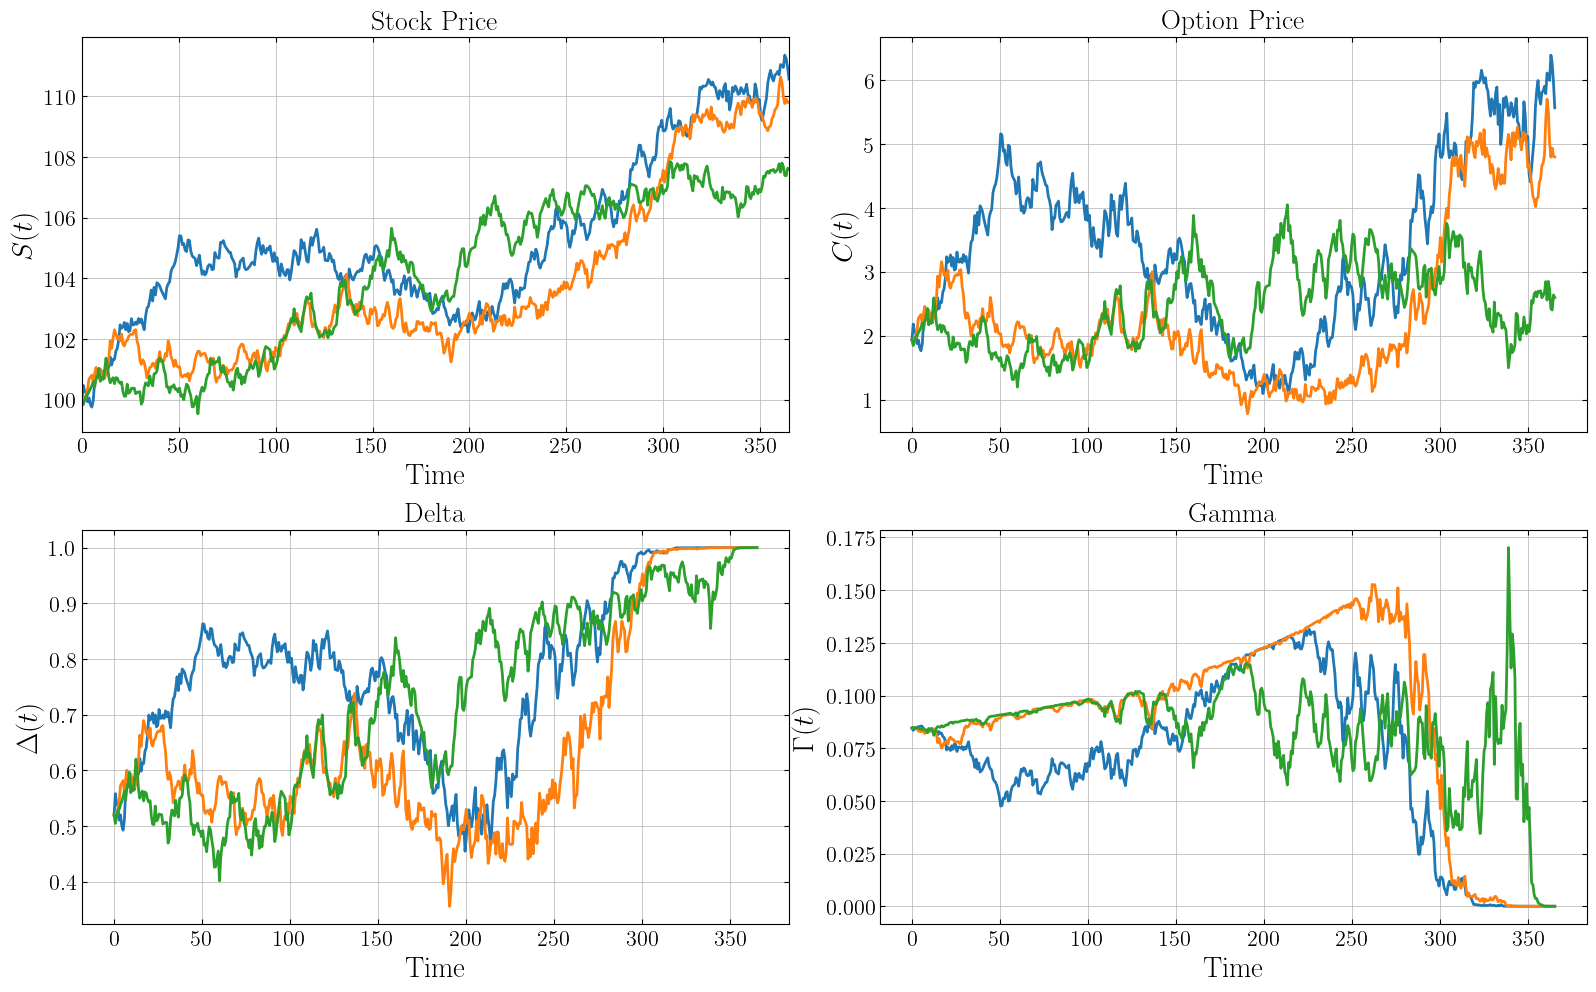

In [5]:
# We generate different Stock paths with the same input parameters
S = BlackScholes(paths, mu, sigma, S0)  

# Parameters for the Call Option
strike_price = 105.
dividend = 0.0

opt1 = Option(S[0,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma, CallPut='Call')
opt2 = Option(S[1,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma, CallPut='Call')
opt3 = Option(S[2,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma, CallPut='Call')

# Delta as a function of the stock price for a long position in a call option on non-dividend 
del1 = delta(S[0,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma, CallPut='Call')
del2 = delta(S[1,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma, CallPut='Call')
del3 = delta(S[2,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma, CallPut='Call')   

ga1 = gamma(S[0,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma)
ga2 = gamma(S[1,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma)
ga3 = gamma(S[2,:], K=strike_price, T=tf, r=mu, q=dividend, sigma=sigma)


fig = plt.figure(figsize=(16,10)) 
ax1 = fig.add_subplot(221); ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223); ax4 = fig.add_subplot(224)
    
ax1.set_title(r'${\rm Stock\,\, Price}$', fontsize=20, color='black')   
ax2.set_title(r'${\rm Option\,\, Price}$', fontsize=20, color='black') 
ax3.set_title(r'${\rm Delta}$', fontsize=20, color='black')   
ax4.set_title(r'${\rm Gamma}$', fontsize=20, color='black')         

lwS = 2.
ax1.plot(time, S[0,:], linewidth=lwS)
ax1.plot(time, S[1,:], linewidth=lwS)
ax1.plot(time, S[2,:], linewidth=lwS)

ax2.plot(time, opt1, linewidth=lwS)
ax2.plot(time, opt2, linewidth=lwS)
ax2.plot(time, opt3, linewidth=lwS)

ax3.plot(time, del1, linewidth=lwS)
ax3.plot(time, del2, linewidth=lwS)
ax3.plot(time, del3, linewidth=lwS)

ax4.plot(time, ga1, linewidth=lwS)
ax4.plot(time, ga2, linewidth=lwS)
ax4.plot(time, ga3, linewidth=lwS)
    
ax1.set_xlabel(r'${\rm Time}$', fontsize=21); ax2.set_xlabel(r'${\rm Time}$', fontsize=21)
ax3.set_xlabel(r'${\rm Time}$', fontsize=21); ax4.set_xlabel(r'${\rm Time}$', fontsize=21)
#ax.set_xscale("log")
ax1.set_xlim(min(time), max(time))

ax1.set_ylabel(r'$S(t)$', fontsize=21)
ax2.set_ylabel(r'$C(t)$', fontsize=21)
ax3.set_ylabel(r'$\Delta(t)$', fontsize=21)
ax4.set_ylabel(r'$\Gamma(t)$', fontsize=21)
#ax.set_yscale("log")
#ax.set_ylim(-.2, .2) #1e-4, 2.0)

#ax.xaxis.set_minor_locator(plt.MultipleLocator(50))
#ax.xaxis.set_major_locator(plt.MultipleLocator(200))
    
plt.tight_layout()
    
# This is needed for to show ticks on four frams in the latest version of matplotlib
ax1.tick_params(axis='both', which='both', direction='in')
ax2.tick_params(axis='both', which='both', direction='in')
ax3.tick_params(axis='both', which='both', direction='in')
ax4.tick_params(axis='both', which='both', direction='in')
ax1.xaxis.set_ticks_position('both'); ax1.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both'); ax2.yaxis.set_ticks_position('both')
ax3.xaxis.set_ticks_position('both'); ax3.yaxis.set_ticks_position('both')
ax4.xaxis.set_ticks_position('both'); ax4.yaxis.set_ticks_position('both')
    
ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax3.tick_params(axis='both', which='major', labelsize=16)
ax4.tick_params(axis='both', which='major', labelsize=16)

ax1.grid(linewidth=0.5); ax2.grid(linewidth=0.5)
ax3.grid(linewidth=0.5); ax4.grid(linewidth=0.5)
   
plt.show()
fig.savefig('plots.png')
#fig.savefig('plots.pdf', format='pdf')   

In [6]:
# ============ The Greeks at t=0, with dependence only on Stock price ============

def delta_t0(S, K, T, r, q, sigma, CallPut):
    # We use the analytical expression for Delta
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2.)*T)/(sigma*np.sqrt(T))

    # For Call option:
    if CallPut == 'Call':
        return ss.norm.cdf(d1)*np.exp(-q*T)
    
    # For Put option:
    elif CallPut == 'Put':
        return ss.norm.cdf(d1)*np.exp(-q*T) - 1.0

def gamma_t0(S, K, T, r, q, sigma):
    # We use the analytical expression for Gamma
    d1 = (np.log(S/K) + (r - q + 0.5*sigma**2.)*T)/(sigma*np.sqrt(T))
    Nprime = np.exp(-d1**2./2.)/np.sqrt(2.*np.pi)    

    # Same for both Call and Put options
    return Nprime/(S*sigma*np.sqrt(T))


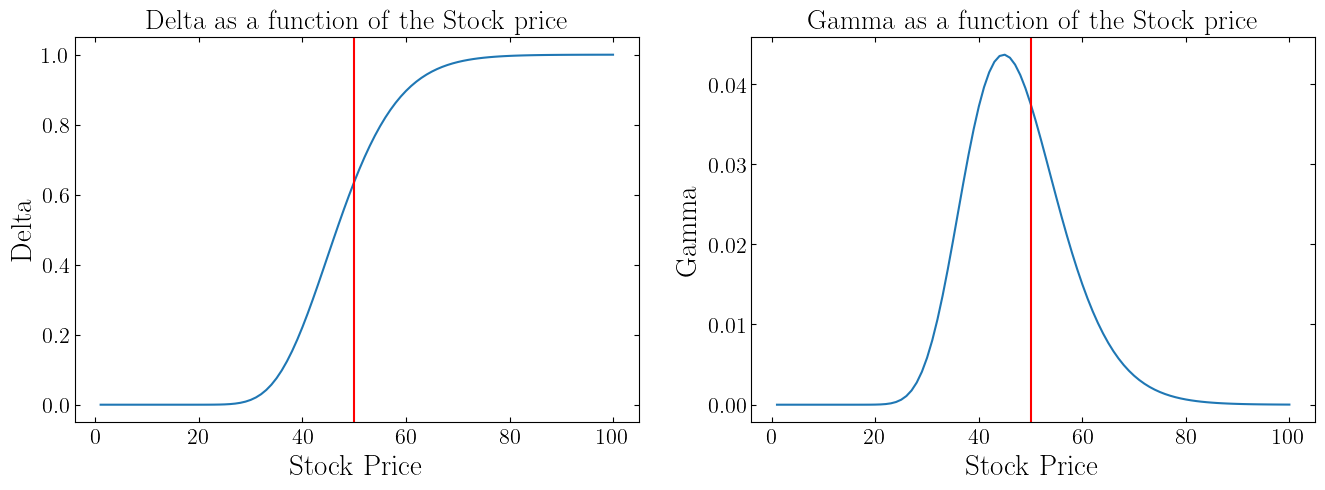

In [7]:
# ============ We show Delta and Gamma only as a function of the Stock Price ============

# Delta as as function of the Stock price for a long position in a call option on non-dividend 
# Parameters: K=50, T = 1 year, r=0.05, sigma=0.2
Slinear = np.linspace(1, 100, 100)
d = delta_t0(Slinear, K=50, T=1.0, r=0.05, q=0.0, sigma=0.2, CallPut='Call')

# Gamma as a function of the Stock price for a call option with no dividend 
# Parameters: K=50, T = 1 year, r=0.05, sigma=0.2
g = gamma_t0(Slinear, K=50, T=1., r=0.05, q=0.0, sigma=0.2)

fig = plt.figure(figsize=(16,5)) 
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)

ax1.plot(Slinear, d)
ax1.axvline(50, ymin=0, ymax=1, color='red', linewidth=1.5)
ax1.set_title('Delta as a function of Stock price for call option')

ax2.plot(Slinear, g)
ax2.axvline(50, ymin=0, ymax=1, color='red', linewidth=1.5)
ax2.set_title('Gamma as a function of Stock price')

ax1.set_title(r'${\rm  Delta\,\, as \,\, a \,\, function \,\, of \,\, the \,\, Stock \,\, price}$', fontsize=20, color='black') 
ax2.set_title(r'${\rm  Gamma\,\, as \,\, a \,\, function \,\, of \,\, the \,\, Stock \,\, price}$', fontsize=20, color='black') 

ax1.set_xlabel(r'${\rm Stock \,\, Price}$', fontsize=21); ax2.set_xlabel(r'${\rm Stock \,\, Price}$', fontsize=21)
ax1.set_ylabel(r'${\rm Delta}$', fontsize=21); ax2.set_ylabel(r'${\rm Gamma}$', fontsize=21)
    
# This is needed for to show ticks on four frams in the latest version of matplotlib
ax1.tick_params(axis='both', which='both', direction='in')
ax2.tick_params(axis='both', which='both', direction='in')
ax1.xaxis.set_ticks_position('both'); ax1.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both'); ax2.yaxis.set_ticks_position('both')

ax1.tick_params(axis='both', which='major', labelsize=16)
ax2.tick_params(axis='both', which='major', labelsize=16)


**Delta-Hedging**

In the Black-Scholes model, the stock price follows a Geometric Brownian motion

\begin{equation}
dS_t = \mu \, S_t \, dt + \sigma \, S_t \, dW_t,
\end{equation}

where $\mu$ is the drift coefficient and $\sigma^2$ corresponds to the volatility.




In [8]:
# =============== Hedging a Short Call with Long Stock ===========================

# Stock price and Delta have been computed above
# Para,eters:
N = 1000
d = del1
St = S[0,:]
r = mu

# We determine the Initial Position
n_shares = [d[0]*N]
cost_of_shares = [n_shares[0]*S0]
cumulative_cost = [n_shares[0]*S0]
interest_cost = [cumulative_cost[0]*r*dt]

# Rebalancing
for i in range(1, len(d)):
    diff = d[i] - d[i-1]
    n_shares.append(diff*N)
    cost_of_shares.append(n_shares[i]*St[i])
    cumulative_cost.append(cost_of_shares[i] + cumulative_cost[i-1] + interest_cost[i-1])
    interest_cost.append(cumulative_cost[i]*r*dt)
    
df = pd.DataFrame({'Stock Price':St, 'Delta':np.round(d, 2),'Shares Purchased':np.array(n_shares),
                    'Cost of Shares':np.round(np.array(cost_of_shares),2),
                    'Cumulative Cost':np.round(np.array(cumulative_cost),2),
                    'Interest Cost':np.array(interest_cost)/1000})

print(df.to_string())

     Stock Price  Delta  Shares Purchased  Cost of Shares  Cumulative Cost  Interest Cost
0     100.000000   0.52      5.196345e+02        51963.45         51963.45       0.005196
1     100.465927   0.56      3.836074e+01         3853.95         55822.59       0.005582
2     100.254853   0.54     -1.851448e+01        -1856.17         53972.00       0.005397
3     100.228611   0.54     -3.038321e+00         -304.53         53672.88       0.005367
4      99.931633   0.51     -2.601373e+01        -2599.59         51078.65       0.005108
5     100.053328   0.52      9.491986e+00          949.70         52033.46       0.005203
6      99.833227   0.50     -1.960549e+01        -1957.28         50081.39       0.005008
7      99.751866   0.49     -7.824391e+00         -780.50         49305.90       0.004931
8      99.972593   0.51      1.798801e+01         1798.31         51109.13       0.005111
9     100.597526   0.56      5.213357e+01         5244.51         56358.75       0.005636
10    100.

**Histogram with Gaussian returns**

We show a histogram with the percentage returns.\
With a vanishing drift $\mu=0$, these should follow a Gaussian distribution.

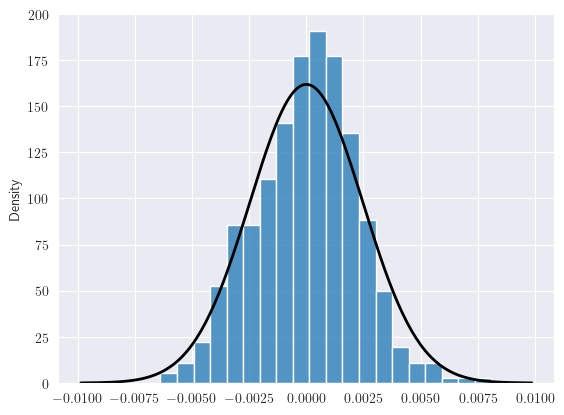

In [57]:
# We generate different Stock paths with the same input parameters
mu = 0 
S = BlackScholes(paths, mu, sigma, S0)  

def normal(mean, std, color="black"):
    '''Plot a Normal distribution with mean = mean and standard deviation = std'''
    x = np.linspace(mean-4*std, mean+4*std, 200)
    p = ss.norm.pdf(x, mean, std)
    z = plt.plot(x, p, color, linewidth=2)

# We calculate the percentage returns
price_diff = [] 
for i in range(len(S[0,:])-1):
    price_diff.append((S[0,i+1]-S[0,i])/S[0,i])    

# Plot the Normal distribution on top of the Histogram   
ax = sns.histplot(x=price_diff, stat="density")
normal(mu, sigma)    